This is a [jupyter](http://jupyter.org) notebook.

Open the notebook by (1) copying this file into a directory, (2) launching jupyter notebook in that directory
and (3) selecting the notebook.

# <u><font color= 'blue'> Playing with Image Filters </font> </u>
### <i>Practical Assignment 2, EE210 (Spring 2017) </i>
___
A notebook by ___Dhruv Ilesh Shah___
___
__Required Packages:__ Python(2.7+), NumPy, MatPlotLib, SciPy.io _(Optional, to simplify IO operations)_
___
In this notebook, I present the effect of simple filters on 2D-images. We begin with the standard method of convoluting, and then enter the frequency domain by computing the two-dimensional Fourier transform and using it to compute the convolution.

## The Problem

Image filtering is a very common technique in today's world - ranging from blurring out sensitive content to improving sharpness and contrast to masking and so on. Unlike the Snapchat filters that require significant processing, many filters can be contrived simply using the convolution operation.

In this report, I present some simple filters with their application and results, on a sample image. At first, I present a simple Python implementation of a blurring filter. In the subsequent section, I have shown some examples of interesting, yet simple, 2D filters.

## Implementation
### The 2D Convolution Operation

Much like the 1D case, the 2D convolution can be represented as below.
$$
f[x, y] * g[x, y] = \sum_{n_1=-\infty}^{\infty} \sum_{n_2=-\infty}^{\infty} f[n_1, n_2]\cdot g[x-n_1, y-n_2]
$$

A direct implementation of the convolution can be done by running nested loops. I have skipped the trivial implementation. Instead, we can directly switch to the implementation by jumping to the frequency domain.

\begin{equation}
\begin{split}
f[x, y] &\xrightarrow{\mathscr{F}} F(s), & \hspace{8em} s \in \mathbb{C}_2 \\
g[x, y] &\xrightarrow{\mathscr{F}} G(s), & \hspace{8em} s \in \mathbb{C}_2 \\
f[x, y] * g[x, y] &\xrightarrow{\mathscr{F}} F[s] \cdot G[s] & 
\end{split}
\end{equation}

Very similar to the analysis of the 1D convolution (presented in assignment 1), we can shift the whole discussion in the Fourier domain to give more efficient computation. In this section, I present an implementation of the 2D convolution using the 2D Fourier transform, which is indeed pretty close to what the SciPy function `convolve2d` and Matlab/Scilab function `conv2` does.

### Full and Valid Convolution
Just like the concept of linear and circular convolution in 1D, we have the notion of full and valid convolution in 2D. Multiplying the Fourier transforms in the frequency domain inherently results in a full convolution, which is not necessarily valid on some portions of the input signal.  
For a valid outcome, we may either need to post-process the output, or perform some zero-padding, which would then enable us to get the real convolution.

In [1]:
from numpy.fft import fft2, ifft2


def fftconvolve2d(x, y, mode="full"):
    """
    x and y must be real 2D numpy arrays.

    mode must be "full" or "valid".
    """
    x_shape = np.array(x.shape)
    y_shape = np.array(y.shape)
    z_shape = x_shape + y_shape - 1
    z = ifft2(fft2(x, z_shape) * fft2(y, z_shape)).real

    if mode == "valid":
        # To compute a valid shape, either np.all(x_shape >= y_shape) or
        # np.all(y_shape >= x_shape).
        valid_shape = x_shape - y_shape + 1
        if np.any(valid_shape < 1):
            valid_shape = y_shape - x_shape + 1
            if np.any(valid_shape < 1):
                raise ValueError("empty result for valid shape")
        start = (z_shape - valid_shape) // 2
        end = start + valid_shape
        z = z[start[0]:end[0], start[1]:end[1]]

    return z

The above function is a generic convolution function for the 2D convolution. It transforms the signals `x` and `y` into the Fourier domain, extends to the size of `size(x) + size(y) - 1` in each dimension. The inverse of the Fourier product gives what is known as the __full convolution__.  
For obtaining the __valid convolution__ instead, we could either post-process this result or zero-pad the input signals. Sticking to the modularity of the above method, we choose to post-process as given above.

## Filters

Before we start off, let's import the images and convert them to grayscale for easy handling. Then, we begin by describing simple filters and then appyling them on our input images. For the demonstration, I have used the image provided, and another image - that of [Tower Bridge, London](https://www.wikiwand.com/en/Tower_Bridge).

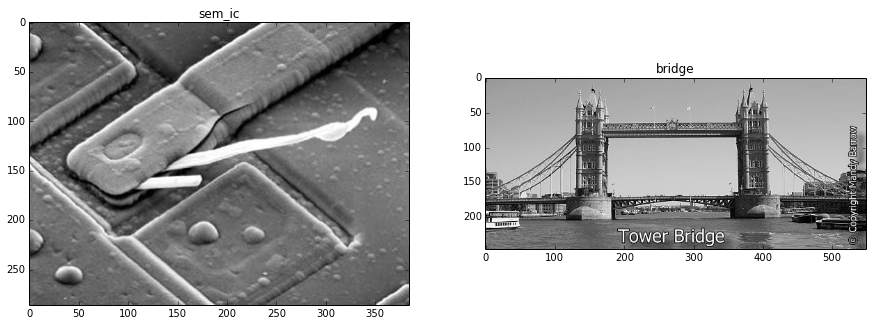

In [2]:
%matplotlib inline

import numpy as np
from scipy import misc # For file handling
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 15]

sem_ic = misc.imread("Image Assignment/sem_ic.jpg", mode="L")
bridge = misc.imread("Image Assignment/bridge.jpg", mode="L")

plt.subplot(2, 2, 2)
plt.imshow(bridge, cmap="gray")
plt.title("bridge")

plt.subplot(2, 2, 1)
plt.imshow(sem_ic, cmap="gray")
plt.title("sem_ic")

Now, let us look at the same images in the Fourier domain.

<matplotlib.colorbar.Colorbar instance at 0x7f75e7002200>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


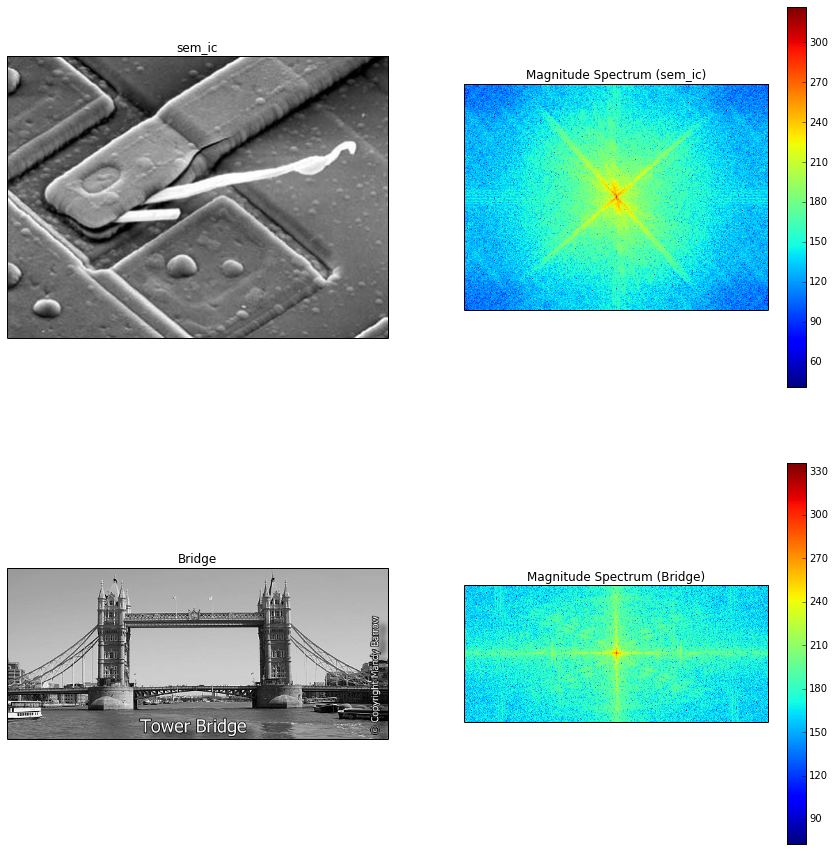

In [3]:
f1 = np.fft.fft2(sem_ic)
fshift1 = np.fft.fftshift(f1)
magnitude_spectrum1 = 20*np.log(np.abs(fshift1))
f2 = np.fft.fft2(bridge)
fshift2 = np.fft.fftshift(f2)
magnitude_spectrum2 = 20*np.log(np.abs(fshift2))


plt.subplot(221),plt.imshow(sem_ic, cmap = 'gray')
plt.title('sem_ic'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum1)
plt.title('Magnitude Spectrum (sem_ic)'), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.subplot(223),plt.imshow(bridge, cmap = 'gray')
plt.title('Bridge'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(magnitude_spectrum2)
plt.title('Magnitude Spectrum (Bridge)'), plt.xticks([]), plt.yticks([])
plt.colorbar()

### Box Blur
This was one of the filters given in the problem statement.
\begin{equation}
\frac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
\end{equation}

From the look of it, it should be a low pass filter. Let us look at the Fourier transform of the filter, and then apply it to the images.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


(<matplotlib.text.Text at 0x7f75e6eb8150>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

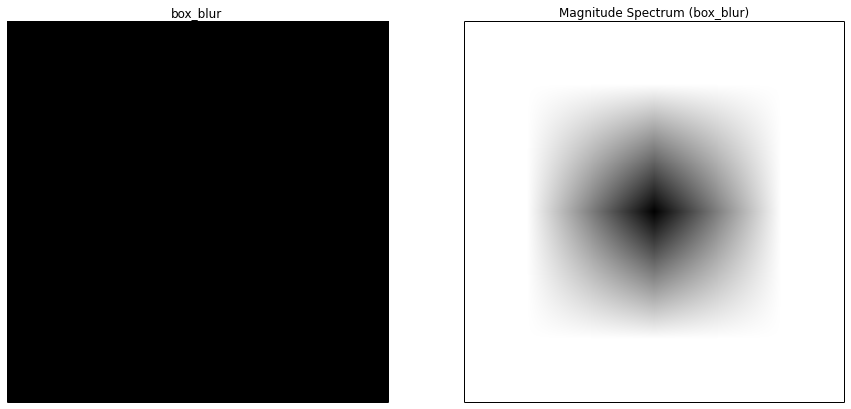

In [4]:
box_blur = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9.


f_box = np.fft.fft2(box_blur)
fshift_box = np.fft.fftshift(f_box)
magnitude_spectrum_box = 20*np.log(np.abs(fshift_box))


plt.subplot(221),plt.imshow(box_blur, cmap = 'gray')
plt.title('box_blur'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum_box, cmap = 'gray')
plt.title('Magnitude Spectrum (box_blur)'), plt.xticks([]), plt.yticks([])

<matplotlib.colorbar.Colorbar instance at 0x7f75e5163b48>

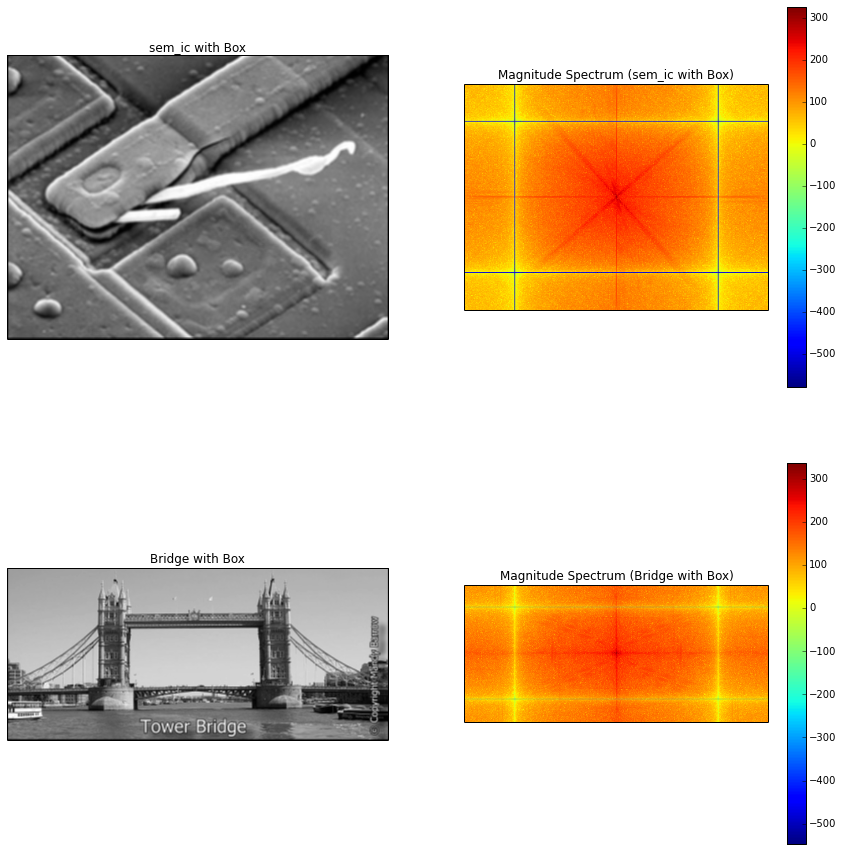

In [5]:
box_blur = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9.
sem_ic_box = fftconvolve2d(sem_ic, box_blur)
bridge_box = fftconvolve2d(bridge, box_blur)

f11 = np.fft.fft2(sem_ic_box)
fshift11 = np.fft.fftshift(f11)
magnitude_spectrum11 = 20*np.log(np.abs(fshift11))
f21 = np.fft.fft2(bridge_box)
fshift21 = np.fft.fftshift(f21)
magnitude_spectrum21 = 20*np.log(np.abs(fshift21))


plt.subplot(221),plt.imshow(sem_ic_box, cmap = 'gray')
plt.title('sem_ic with Box'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum11)
plt.title('Magnitude Spectrum (sem_ic with Box)'), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.subplot(223),plt.imshow(bridge_box, cmap = 'gray')
plt.title('Bridge with Box'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(magnitude_spectrum21)
plt.title('Magnitude Spectrum (Bridge with Box)'), plt.xticks([]), plt.yticks([])
plt.colorbar()

We can see that the above filter does result in blurring of the image, but considering the size, the effect is almost unnoticeable. It can be noticed if we increase the size of the applied box.  
_The colormap has been applied to provide a sense of magnitude to the damped amplitudes. Compare relative magnitudes only, as Fourier transformation involved multiplicative constants._

<matplotlib.colorbar.Colorbar instance at 0x7f75e4e44638>

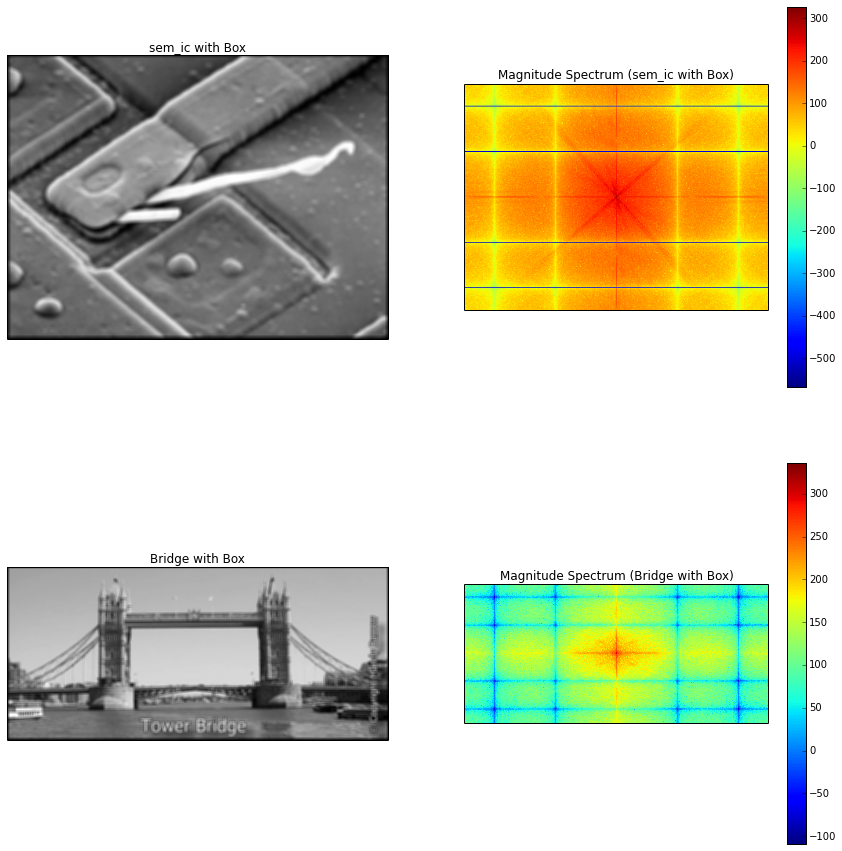

In [6]:
box_blur = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]) / 25.
sem_ic_box = fftconvolve2d(sem_ic, box_blur)
bridge_box = fftconvolve2d(bridge, box_blur)

f11 = np.fft.fft2(sem_ic_box)
fshift11 = np.fft.fftshift(f11)
magnitude_spectrum11 = 20*np.log(np.abs(fshift11))
f21 = np.fft.fft2(bridge_box)
fshift21 = np.fft.fftshift(f21)
magnitude_spectrum21 = 20*np.log(np.abs(fshift21))


plt.subplot(221),plt.imshow(sem_ic_box, cmap = 'gray')
plt.title('sem_ic with Box'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum11)
plt.title('Magnitude Spectrum (sem_ic with Box)'), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.subplot(223),plt.imshow(bridge_box, cmap = 'gray')
plt.title('Bridge with Box'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(magnitude_spectrum21)
plt.title('Magnitude Spectrum (Bridge with Box)'), plt.xticks([]), plt.yticks([])
plt.colorbar()

_Here we can clearly see the blurring in action!_ 

## Edge Detection
This was another one of the filters given in the problem statement.  

\begin{bmatrix}
0 & -1 & 0 \\
-1 & 4 & -1 \\
0 & -1 & 0
\end{bmatrix}

From the look of it, it can detect edges in the picture, due to abrupt pixel changes. Let us look at what the image looks like, after application.  

A better implementation of the above filter would be of the following form:
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & -2 & 0 & 0 \\
0 & -2 & 8 & -2 & 0 \\
0 & 0 & -2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}

<matplotlib.colorbar.Colorbar instance at 0x7f75e4a99e60>

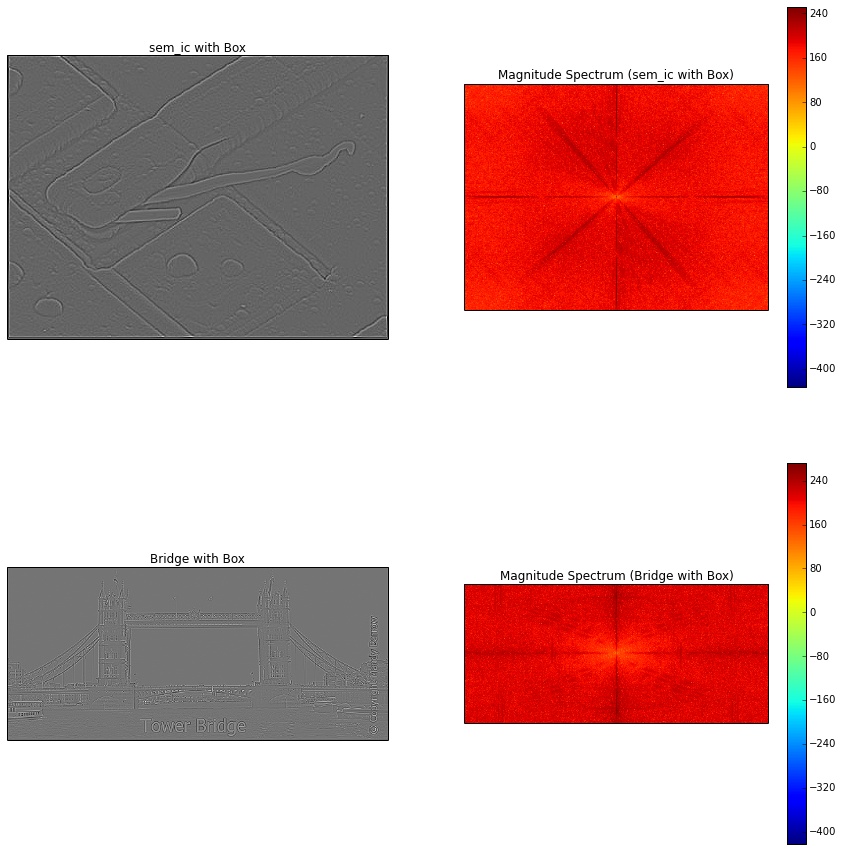

In [7]:
edges = np.array([[0, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, -2, 8, -2, 0], [0, 0, -2, 0, 0], [0, 0, 0, 0, 0]])
sem_ic_edge = fftconvolve2d(sem_ic, edges)
bridge_edge = fftconvolve2d(bridge, edges)

f12 = np.fft.fft2(sem_ic_edge)
fshift12 = np.fft.fftshift(f12)
magnitude_spectrum12 = 20*np.log(np.abs(fshift12))
f22 = np.fft.fft2(bridge_edge)
fshift22 = np.fft.fftshift(f22)
magnitude_spectrum22 = 20*np.log(np.abs(fshift22))


plt.subplot(221),plt.imshow(sem_ic_edge, cmap = 'gray')
plt.title('sem_ic with Box'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum12)
plt.title('Magnitude Spectrum (sem_ic with Box)'), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.subplot(223),plt.imshow(bridge_edge, cmap = 'gray')
plt.title('Bridge with Box'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(magnitude_spectrum22)
plt.title('Magnitude Spectrum (Bridge with Box)'), plt.xticks([]), plt.yticks([])
plt.colorbar()

I am unable to draw any specific conclusion from the Fourier plots, but the grayscale plots clearly show what we are looking for! The edges are clearly highlighted, and can be seen.

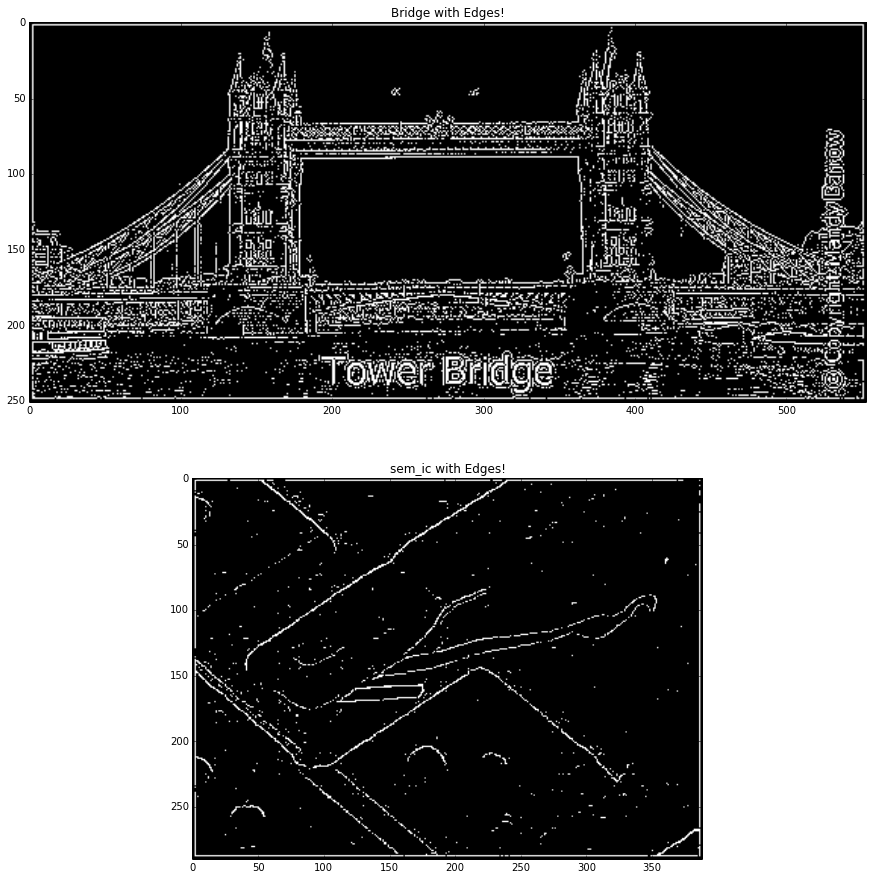

In [8]:
# To extract the edges, we can do a simple binary threshold!
def threshold(image, thresh):
    dim = image.shape
    img_thresh = np.zeros(dim)
    for i in range(dim[0]):
        for j in range(dim[1]):
            if image[i, j] > thresh: img_thresh[i, j] = 255
            else: img_thresh[i, j] = 0
    return img_thresh

bridge_edge = threshold(bridge_edge, 100)
sem_ic_edge = threshold(sem_ic_edge, 100)
plt.subplot(2, 1, 1)
plt.imshow(bridge_edge, cmap = "gray")
plt.title("Bridge with Edges!")
plt.subplot(2, 1, 2)
plt.imshow(sem_ic_edge, cmap = "gray")
plt.title("sem_ic with Edges!")

## Edge Detector Revisited
A more sensitive edge detector can be described as follows.

\begin{bmatrix}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1
\end{bmatrix}

This will respond not just to horizontal, vertical, but also to most slants. Let's see this in action.

<matplotlib.colorbar.Colorbar instance at 0x7f75e46c3680>

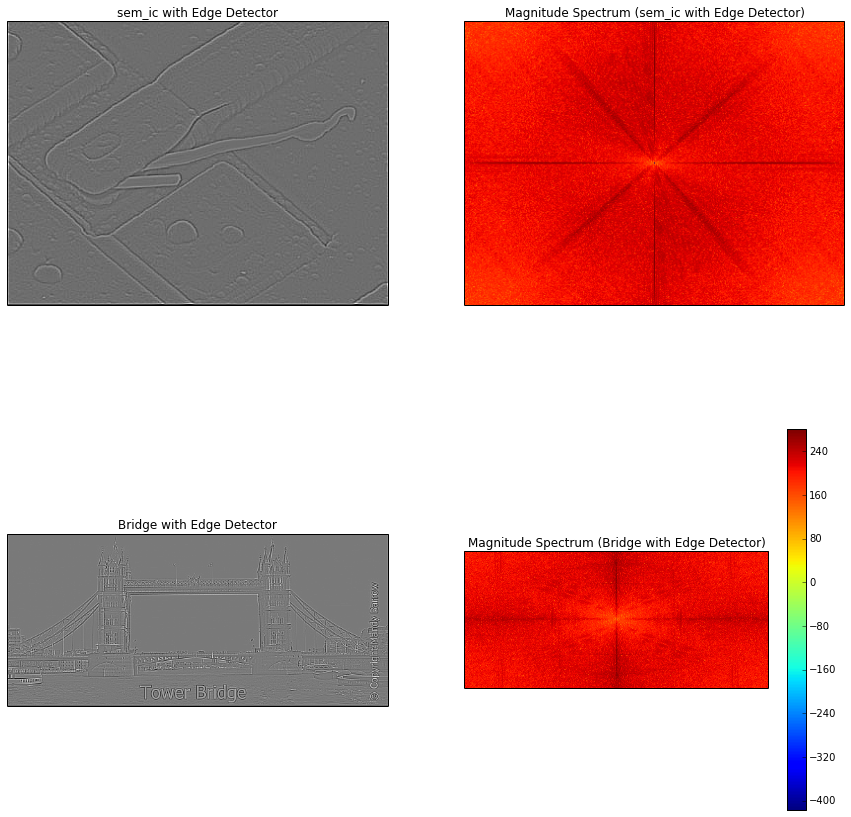

In [9]:
edges = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
sem_ic_edge = fftconvolve2d(sem_ic, edges)
bridge_edge = fftconvolve2d(bridge, edges)

f12 = np.fft.fft2(sem_ic_edge)
fshift12 = np.fft.fftshift(f12)
magnitude_spectrum12 = 20*np.log(np.abs(fshift12))
f22 = np.fft.fft2(bridge_edge)
fshift22 = np.fft.fftshift(f22)
magnitude_spectrum22 = 20*np.log(np.abs(fshift22))


plt.subplot(221),plt.imshow(sem_ic_edge, cmap = 'gray')
plt.title('sem_ic with Edge Detector'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum12)
plt.title('Magnitude Spectrum (sem_ic with Edge Detector)'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(bridge_edge, cmap = 'gray')
plt.title('Bridge with Edge Detector'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(magnitude_spectrum22)
plt.title('Magnitude Spectrum (Bridge with Edge Detector)'), plt.xticks([]), plt.yticks([])
plt.colorbar()

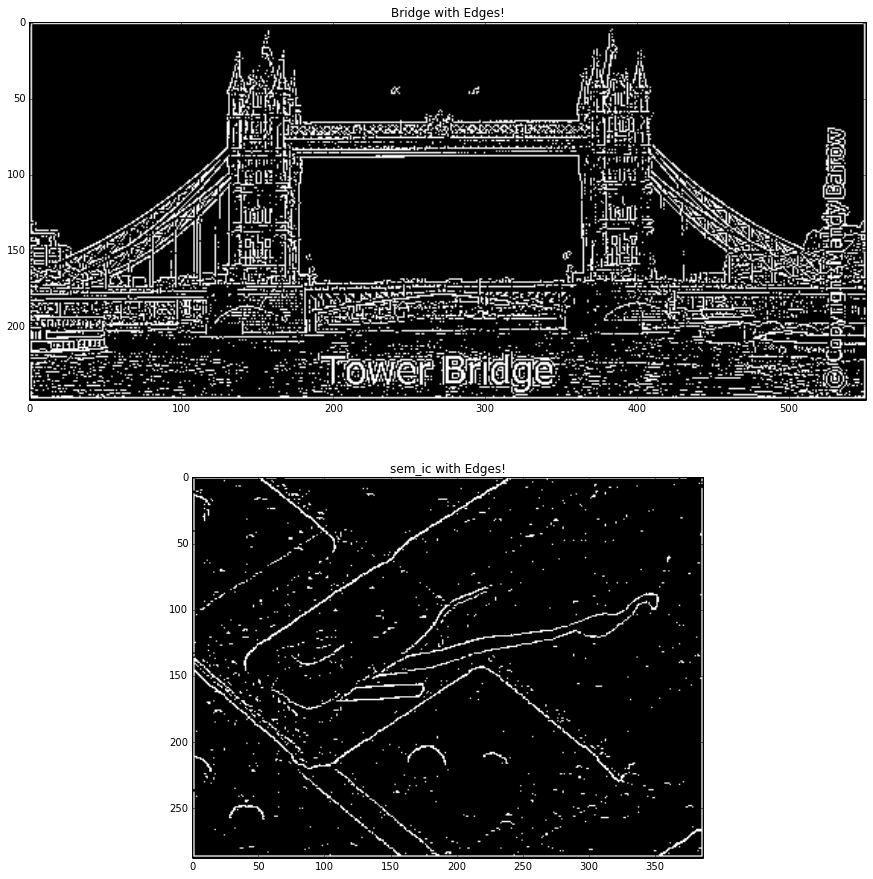

In [10]:
bridge_edge = threshold(bridge_edge, 100)
sem_ic_edge = threshold(sem_ic_edge, 100)
plt.subplot(2, 1, 1)
plt.imshow(bridge_edge, cmap = "gray")
plt.title("Bridge with Edges!")
plt.subplot(2, 1, 2)
plt.imshow(sem_ic_edge, cmap = "gray")
plt.title("sem_ic with Edges!")

## Sharpening

Image sharpening is a very common practice, and is very much like emphasising the edges on an existing image. Hence we can simply take the existing edge detector, and add the unity convolution.

\begin{bmatrix}
0 & -1 & 0 \\
-1 & 5 & -1 \\
0 & -1 & 0
\end{bmatrix}

<matplotlib.colorbar.Colorbar instance at 0x7f75e426c290>

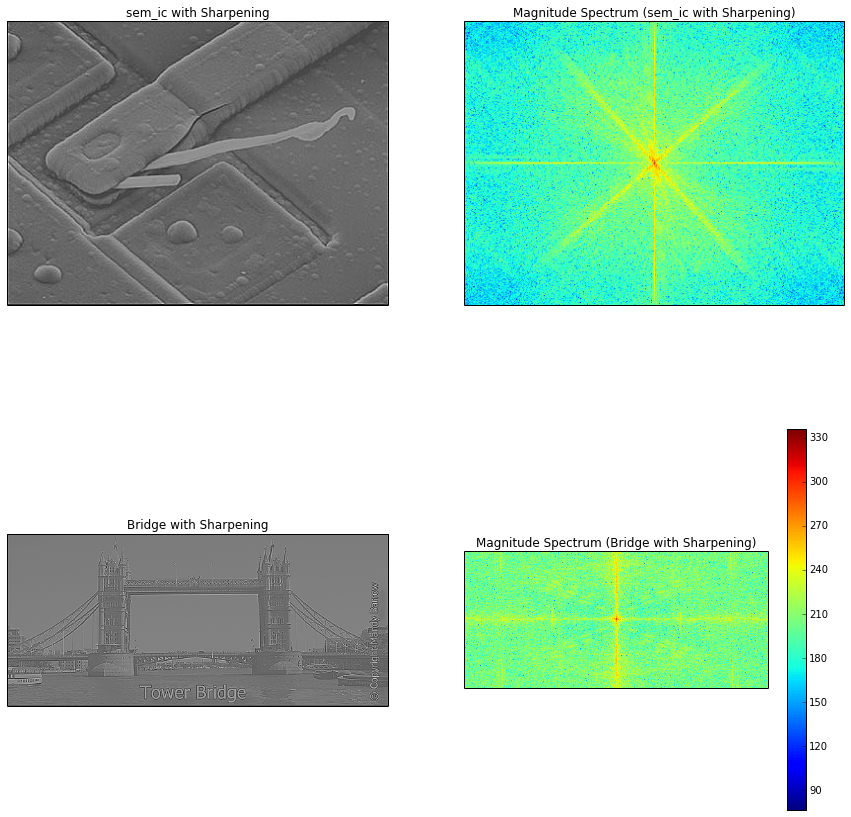

In [11]:
sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sem_ic_sharp = fftconvolve2d(sem_ic, sharpen)
bridge_sharp = fftconvolve2d(bridge, sharpen)

f12 = np.fft.fft2(sem_ic_sharp)
fshift12 = np.fft.fftshift(f12)
magnitude_spectrum12 = 20*np.log(np.abs(fshift12))
f22 = np.fft.fft2(bridge_sharp)
fshift22 = np.fft.fftshift(f22)
magnitude_spectrum22 = 20*np.log(np.abs(fshift22))


plt.subplot(221),plt.imshow(sem_ic_sharp, cmap = 'gray')
plt.title('sem_ic with Sharpening'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum12)
plt.title('Magnitude Spectrum (sem_ic with Sharpening)'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(bridge_sharp, cmap = 'gray')
plt.title('Bridge with Sharpening'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(magnitude_spectrum22)
plt.title('Magnitude Spectrum (Bridge with Sharpening)'), plt.xticks([]), plt.yticks([])
plt.colorbar()

## Emboss
To wind up, here is a kernel for the _emboss_ filter. This adds a 3D shadow effect to the image.

\begin{bmatrix}
-2 & -1 & 0 \\
-1 & 1 & 1 \\
0 & 1 & 2
\end{bmatrix}

<matplotlib.colorbar.Colorbar instance at 0x7f75dff8a128>

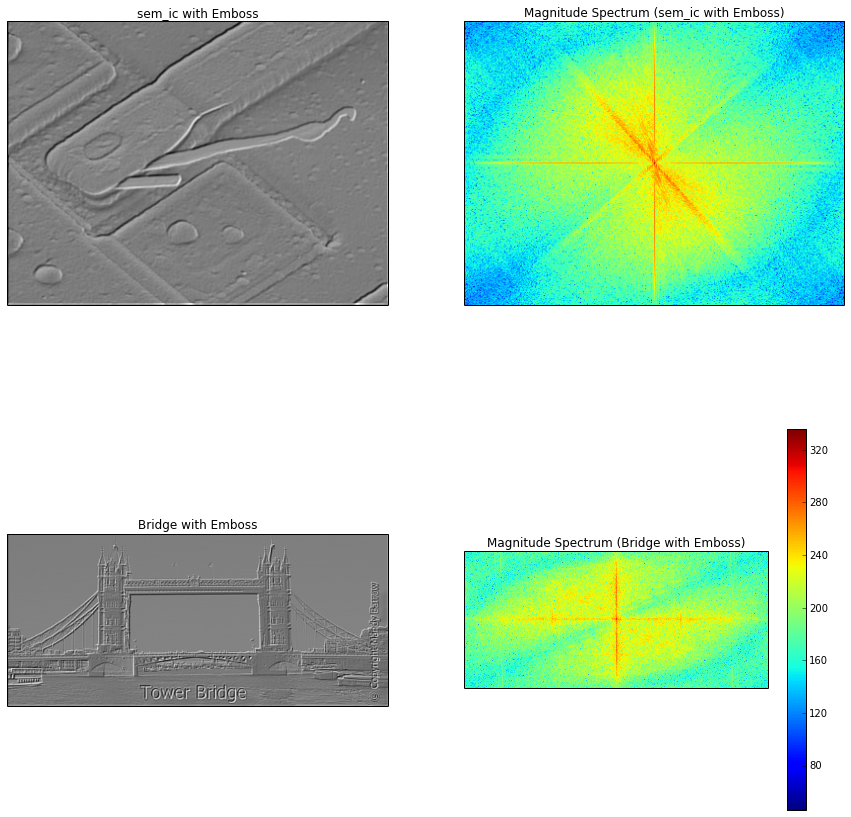

In [12]:
emboss = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
sem_ic_emboss = fftconvolve2d(sem_ic, emboss)
bridge_emboss = fftconvolve2d(bridge, emboss)

f12 = np.fft.fft2(sem_ic_emboss)
fshift12 = np.fft.fftshift(f12)
magnitude_spectrum12 = 20*np.log(np.abs(fshift12))
f22 = np.fft.fft2(bridge_emboss)
fshift22 = np.fft.fftshift(f22)
magnitude_spectrum22 = 20*np.log(np.abs(fshift22))


plt.subplot(221),plt.imshow(sem_ic_emboss, cmap = 'gray')
plt.title('sem_ic with Emboss'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum12)
plt.title('Magnitude Spectrum (sem_ic with Emboss)'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(bridge_emboss, cmap = 'gray')
plt.title('Bridge with Emboss'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(magnitude_spectrum22)
plt.title('Magnitude Spectrum (Bridge with Emboss)'), plt.xticks([]), plt.yticks([])
plt.colorbar()

The output of the emboss filter sure looks very cool! In a similar manner, multiple filters can be constructed and _very_ easily implemented by convolution.  

___ Thank You! ___